In [1]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import config

# Setup paths
print("Loading configuration...")
print(f"Dataset directory: {config.DATASET_DIR}")
print(f"Model results: {config.MODEL_RESULT_PATH}")

Loading configuration...
Dataset directory: c:\Users\swapn\code\AI Healthcare Imaging\datasets
Model results: c:\Users\swapn\code\AI Healthcare Imaging\results


## 1. Download and Check Dataset

Uses kagglehub to download the dataset locally.

In [ ]:
# Download dataset using Kaggle API
import shutil
import os

# Workaround for Kaggle API bug - set env var BEFORE importing kaggle
if "KAGGLE_API_TOKEN" not in os.environ:
    os.environ["KAGGLE_API_TOKEN"] = ""

from kaggle.api.kaggle_api_extended import KaggleApi

DATASET_DIR = Path(config.DATASET_DIR)

# Download dataset directly if not already there
if not DATASET_DIR.exists() or not (DATASET_DIR / "imagesTr").exists():
    print(f"Downloading dataset to: {DATASET_DIR}")
    
    # Initialize Kaggle API
    api = KaggleApi()
    
    # Download dataset
    DATASET_DIR.mkdir(parents=True, exist_ok=True)
    
    api.dataset_download_files(
        config.KAGGLE_DATASET,
        path=DATASET_DIR,
        unzip=True,
        quiet=False
    )
    
    # Move Task02_Heart contents up to DATASET_DIR if needed
    task_dir = DATASET_DIR / "Task02_Heart"
    if task_dir.exists():
        for item in task_dir.iterdir():
            shutil.move(str(item), str(DATASET_DIR / item.name))
        task_dir.rmdir()
    
    # Clean up macOS/archive artifacts (._* files)
    artifact_files = list(DATASET_DIR.rglob("._*"))
    if artifact_files:
        print(f"Cleaning up {len(artifact_files)} artifact files (._*)...")
        for artifact in artifact_files:
            artifact.unlink()
        print("Artifact files removed")
    
    print("Dataset downloaded to datasets/ directory")
else:
    print("Using existing dataset in project directory")

# Use local dataset directory
images_path = DATASET_DIR / "imagesTr"
labels_path = DATASET_DIR / "labelsTr"

if images_path.exists() and labels_path.exists():
    print("Dataset structure verified")
    print(f"  Images: {images_path}")
    print(f"  Labels: {labels_path}")
else:
    print("WARNING: Dataset structure not as expected")


✓ Using existing dataset in project directory
✓ Dataset structure verified
  Images: c:\Users\swapn\code\AI Healthcare Imaging\datasets\imagesTr
  Labels: c:\Users\swapn\code\AI Healthcare Imaging\datasets\labelsTr


## 2. Explore Dataset Files

In [3]:
import glob

# Get all files
all_images = sorted(glob.glob(str(images_path / "*.nii")))
all_labels = sorted(glob.glob(str(labels_path / "*.nii")))

print(f"Total images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")
print("\nSample files:")
for i in range(min(3, len(all_images))):
    print(f"  {Path(all_images[i]).name}")

Total images: 20
Total labels: 20

Sample files:
  la_003.nii
  la_004.nii
  la_005.nii


## 3. Load and Visualize Sample Image

In [4]:
import nibabel as nib

# Load first image and label
sample_image = nib.load(all_images[0])
sample_label = nib.load(all_labels[0])

image_data = sample_image.get_fdata()
label_data = sample_label.get_fdata()

print(f"Image shape: {image_data.shape}")
print(f"Label shape: {label_data.shape}")
print(f"Image intensity range: [{image_data.min():.2f}, {image_data.max():.2f}]")
print(f"Unique label values: {np.unique(label_data)}")

Image shape: (320, 320, 130)
Label shape: (320, 320, 130)
Image intensity range: [0.00, 1999.00]
Unique label values: [0. 1.]
Unique label values: [0. 1.]


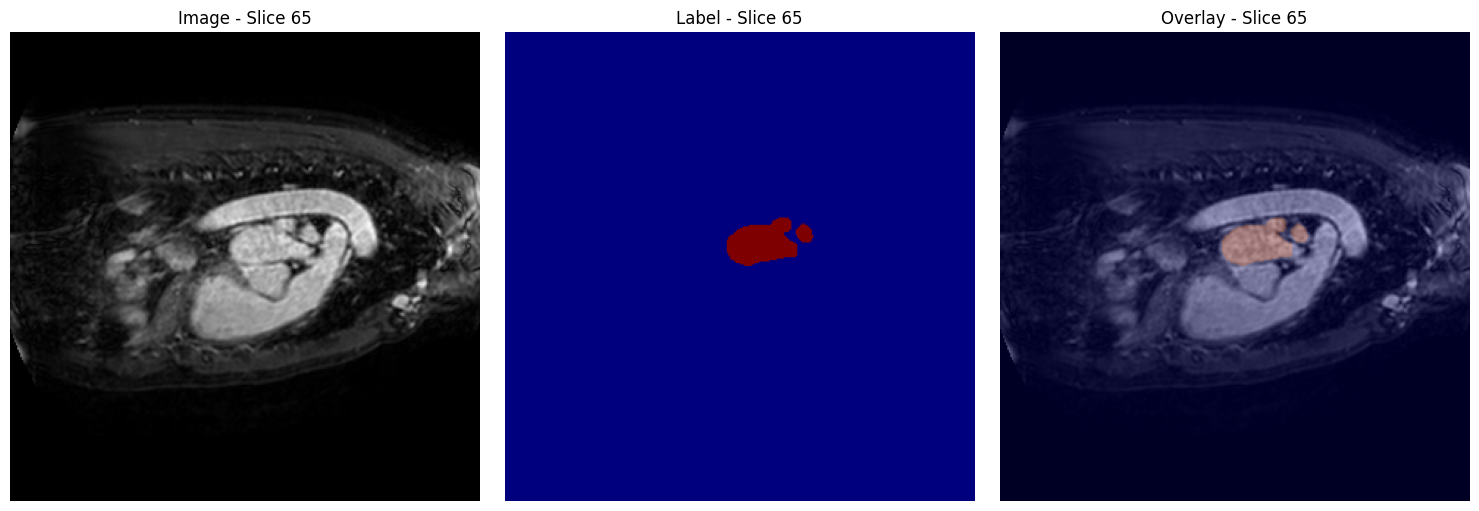

In [5]:
# Visualize middle slices
slice_idx = image_data.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_data[:, :, slice_idx], cmap='gray')
axes[0].set_title(f'Image - Slice {slice_idx}')
axes[0].axis('off')

axes[1].imshow(label_data[:, :, slice_idx], cmap='jet')
axes[1].set_title(f'Label - Slice {slice_idx}')
axes[1].axis('off')

# Overlay
axes[2].imshow(image_data[:, :, slice_idx], cmap='gray')
axes[2].imshow(label_data[:, :, slice_idx], cmap='jet', alpha=0.3)
axes[2].set_title(f'Overlay - Slice {slice_idx}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Interactive slice viewer with slider
from ipywidgets import interact, IntSlider

@interact(slice_idx=IntSlider(min=0, max=image_data.shape[2]-1, step=1, value=image_data.shape[2]//2, description='Slice:'))
def show_slice(slice_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image_data[:, :, slice_idx], cmap='gray')
    axes[0].set_title(f'Image - Slice {slice_idx}')
    axes[0].axis('off')
    
    axes[1].imshow(label_data[:, :, slice_idx], cmap='jet')
    axes[1].set_title(f'Label - Slice {slice_idx}')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(image_data[:, :, slice_idx], cmap='gray')
    axes[2].imshow(label_data[:, :, slice_idx], cmap='jet', alpha=0.3)
    axes[2].set_title(f'Overlay - Slice {slice_idx}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=65, description='Slice:', max=129), Output()), _dom_classes=('widget-int…

## 4. Prepare Data Loaders

Load data using MONAI transforms (same as training).

In [ ]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    Orientationd, Spacingd, ToTensord, DivisiblePadd, CropForegroundd
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

set_determinism(seed=config.SEED)

# Create data dicts
data_dicts = [
    {"image": image, "label": label}
    for image, label in zip(all_images[:5], all_labels[:5])  # First 5 for quick exploration
]

# Define transforms (same as training for consistency)
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=config.PIXDIM, mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS", labels=None),
    ScaleIntensityRanged(keys=["image"], a_min=config.A_MIN, a_max=config.A_MAX, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    # Pad to ensure dimensions are divisible by 16 (UNet with 4 downsampling layers: 2^4=16)
    DivisiblePadd(keys=["image", "label"], k=16),
    ToTensord(keys=["image", "label"]),
])

# Create dataset
dataset = Dataset(data=data_dicts, transform=transforms)
dataloader = DataLoader(dataset, batch_size=1)

print(f"Created dataset with {len(dataset)} samples")


✓ Created dataset with 5 samples


Transformed image shape: torch.Size([208, 272, 192])
Transformed label shape: torch.Size([208, 272, 192])


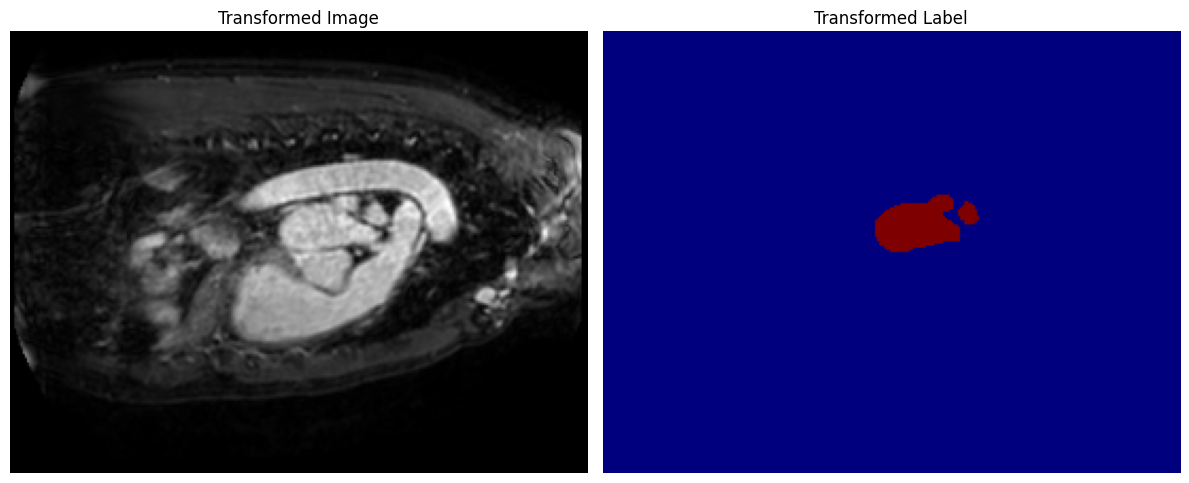

In [8]:
# Visualize transformed data
from monai.utils import first

sample = first(dataloader)
image_tensor = sample["image"][0, 0]  # Remove batch and channel dims
label_tensor = sample["label"][0, 0]

print(f"Transformed image shape: {image_tensor.shape}")
print(f"Transformed label shape: {label_tensor.shape}")

# Visualize middle slice
slice_idx = image_tensor.shape[2] // 2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image_tensor[:, :, slice_idx].cpu().numpy(), cmap='gray')
axes[0].set_title('Transformed Image')
axes[0].axis('off')

axes[1].imshow(label_tensor[:, :, slice_idx].cpu().numpy(), cmap='jet')
axes[1].set_title('Transformed Label')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 5. Train the Model

Train a 3D UNet model with all the features from train.py.

In [ ]:
# Prepare full training dataset (all images, not just 5)
from monai.transforms import RandFlipd, RandRotate90d, RandShiftIntensityd
import random

random.seed(config.SEED)

# Create data dicts for all images
all_data_dicts = [
    {"image": image, "label": label}
    for image, label in zip(all_images, all_labels)
]

# Shuffle and split
random.shuffle(all_data_dicts)
split_idx = int(len(all_data_dicts) * config.TRAIN_RATIO)
train_files = all_data_dicts[:split_idx]
test_files = all_data_dicts[split_idx:]

print(f"Training samples: {len(train_files)}, Validation samples: {len(test_files)}")

# Training transforms with augmentation
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=config.PIXDIM, mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS", labels=None),
    ScaleIntensityRanged(keys=["image"], a_min=config.A_MIN, a_max=config.A_MAX, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    DivisiblePadd(keys=["image", "label"], k=16),
    # Data augmentation
    RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.5),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=(0, 1)),
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
    ToTensord(keys=["image", "label"]),
])

# Test transforms without augmentation
test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=config.PIXDIM, mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS", labels=None),
    ScaleIntensityRanged(keys=["image"], a_min=config.A_MIN, a_max=config.A_MAX, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    DivisiblePadd(keys=["image", "label"], k=16),
    ToTensord(keys=["image", "label"]),
])

# Create datasets
train_ds = Dataset(data=train_files, transform=train_transforms)
test_ds = Dataset(data=test_files, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=config.BATCH_SIZE, num_workers=0)

print("Training and validation loaders ready")


Training samples: 16, Validation samples: 4
✓ Training and validation loaders ready


In [10]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

CUDA available: False


In [ ]:
# Create model and training components
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from tqdm import tqdm

# Ensure results directory exists
results_path = Path(config.MODEL_RESULT_PATH)
results_path.mkdir(parents=True, exist_ok=True)
print(f"Results directory: {results_path}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create model
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# Loss and optimizer
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY, amsgrad=True)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Training parameters
max_epochs = config.MAX_EPOCHS_LOCAL  # Use local epochs for notebook
print("\nModel and training components ready")
print(f"Training for {max_epochs} epoch(s)")


✓ Results directory: c:\Users\swapn\code\AI Healthcare Imaging\results
Using device: cpu

✓ Model and training components ready
Training for 1 epoch(s)

✓ Model and training components ready
Training for 1 epoch(s)


In [ ]:
# Training loop
best_metric = -1
best_metric_epoch = -1
save_loss_train = []
save_loss_test = []
save_metric_train = []
save_metric_test = []

print("\n" + "="*50)
print("Starting Training...")
print("="*50)

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch + 1}/{max_epochs}")
    print("-" * 50)
    
    # Training phase
    model.train()
    epoch_loss = 0
    epoch_metric_train = 0
    step = 0
    
    train_pbar = tqdm(train_loader, desc="Training")
    for batch_data in train_pbar:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate training metric
        dice_metric(y_pred=outputs, y=labels)
        
        train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    epoch_loss /= step
    epoch_metric_train = dice_metric.aggregate().item()
    dice_metric.reset()
    
    save_loss_train.append(epoch_loss)
    save_metric_train.append(epoch_metric_train)
    
    print(f"Training Loss: {epoch_loss:.4f}")
    print(f"Training Dice: {epoch_metric_train:.4f}")
    
    # Save training metrics
    np.save(results_path / 'loss_train.npy', save_loss_train)
    np.save(results_path / 'metric_train.npy', save_metric_train)
    
    # Validation phase
    if (epoch + 1) % config.TEST_INTERVAL == 0:
        model.eval()
        with torch.no_grad():
            test_epoch_loss = 0
            epoch_metric_test = 0
            test_step = 0
            
            test_pbar = tqdm(test_loader, desc="Validation")
            for test_data in test_pbar:
                test_step += 1
                test_inputs, test_labels = test_data["image"].to(device), test_data["label"].to(device)
                
                test_outputs = model(test_inputs)
                test_loss = loss_function(test_outputs, test_labels)
                test_epoch_loss += test_loss.item()
                
                dice_metric(y_pred=test_outputs, y=test_labels)
                test_pbar.set_postfix({"loss": f"{test_loss.item():.4f}"})
            
            test_epoch_loss /= test_step
            epoch_metric_test = dice_metric.aggregate().item()
            dice_metric.reset()
            
            save_loss_test.append(test_epoch_loss)
            save_metric_test.append(epoch_metric_test)
            
            print(f"Validation Loss: {test_epoch_loss:.4f}")
            print(f"Validation Dice: {epoch_metric_test:.4f}")
            
            # Save validation metrics
            try:
                np.save(results_path / 'loss_test.npy', save_loss_test)
                np.save(results_path / 'metric_test.npy', save_metric_test)
            except OSError as e:
                print(f"WARNING: Failed to save metrics (disk space?): {e}")
            
            # Update learning rate
            scheduler.step(epoch_metric_test)
            
            # Save best model
            if epoch_metric_test > best_metric:
                best_metric = epoch_metric_test
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), Path(config.MODEL_RESULT_PATH) / "best_metric_model.pth")
                print(f"New best model saved! Dice: {best_metric:.4f}")
            
            print(f"Best Dice: {best_metric:.4f} at epoch {best_metric_epoch}")

print("\n" + "="*50)
print("Training completed!")
print(f"Best metric: {best_metric:.4f} at epoch {best_metric_epoch}")
print("="*50)


Starting Training...

Epoch 1/1
--------------------------------------------------


Training: 100%|██████████| 16/16 [02:59<00:00, 11.23s/it, loss=0.5988]


Training Loss: 0.6017
Training Dice: 0.5035


Validation: 100%|██████████| 4/4 [00:13<00:00,  3.49s/it, loss=0.6080]

Validation Loss: 0.6050
Validation Dice: 0.5042
✓ New best model saved! Dice: 0.5042
Best Dice: 0.5042 at epoch 1

Training completed!
Best metric: 0.5042 at epoch 1


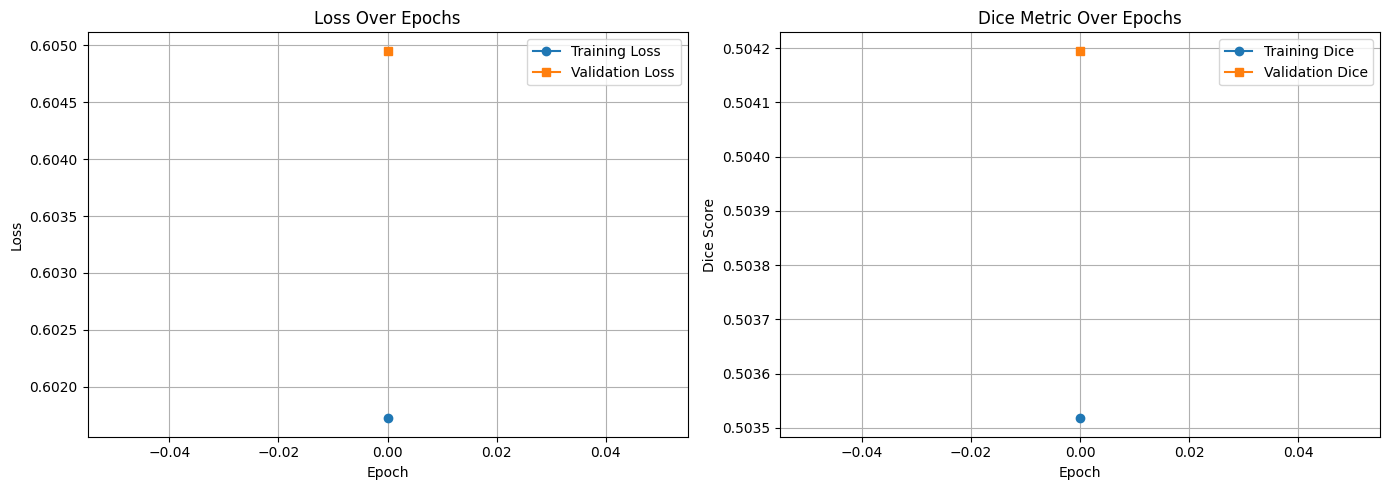


Final Results:
  Training Dice: 0.5035
  Validation Dice: 0.5042
  Best Validation Dice: 0.5042 (Epoch 1)


In [13]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(save_loss_train, label='Training Loss', marker='o')
if save_loss_test:
    axes[0].plot(np.arange(0, len(save_loss_train), config.TEST_INTERVAL), save_loss_test, label='Validation Loss', marker='s')
axes[0].set_title("Loss Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(save_metric_train, label='Training Dice', marker='o')
if save_metric_test:
    axes[1].plot(np.arange(0, len(save_metric_train), config.TEST_INTERVAL), save_metric_test, label='Validation Dice', marker='s')
axes[1].set_title("Dice Metric Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Score")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(f"  Training Dice: {save_metric_train[-1]:.4f}")
if save_metric_test:
    print(f"  Validation Dice: {save_metric_test[-1]:.4f}")
print(f"  Best Validation Dice: {best_metric:.4f} (Epoch {best_metric_epoch})")

In [ ]:
# Verify saved metrics files
print("Saved metrics files:")
for file in ['loss_train.npy', 'metric_train.npy', 'loss_test.npy', 'metric_test.npy']:
    file_path = results_path / file
    if file_path.exists():
        data = np.load(file_path)
        print(f"  {file}: shape={data.shape}, latest value={data[-1]:.4f}")
    else:
        print(f"  {file}: not found")


Saved metrics files:
  ✓ loss_train.npy: shape=(1,), latest value=0.6017
  ✓ metric_train.npy: shape=(1,), latest value=0.5035
  ✓ loss_test.npy: shape=(1,), latest value=0.6050
  ✓ metric_test.npy: shape=(1,), latest value=0.5042


## 6. Run Inference on Trained Model

Load the best trained model and run inference.

In [15]:
# Load the best model for inference
model.load_state_dict(torch.load(Path(config.MODEL_RESULT_PATH) / "best_metric_model.pth", map_location=device))
model.eval()
print(f"✓ Best model loaded (Dice: {best_metric:.4f})")

✓ Best model loaded (Dice: 0.5042)


## 7. Visualize Predictions

In [16]:
# Run inference on test set samples
model.eval()
with torch.no_grad():
    # Get a sample from test loader
    for test_data in test_loader:
        image = test_data["image"].to(device)
        label = test_data["label"].to(device)
        
        # Forward pass
        output = model(image)
        
        # Get prediction (argmax)
        prediction = torch.argmax(output, dim=1, keepdim=True)
        
        print(f"Input shape: {image.shape}")
        print(f"Output shape: {output.shape}")
        print(f"Prediction shape: {prediction.shape}")
        break  # Just use first sample

Input shape: torch.Size([1, 1, 176, 272, 128])
Output shape: torch.Size([1, 2, 176, 272, 128])
Prediction shape: torch.Size([1, 1, 176, 272, 128])


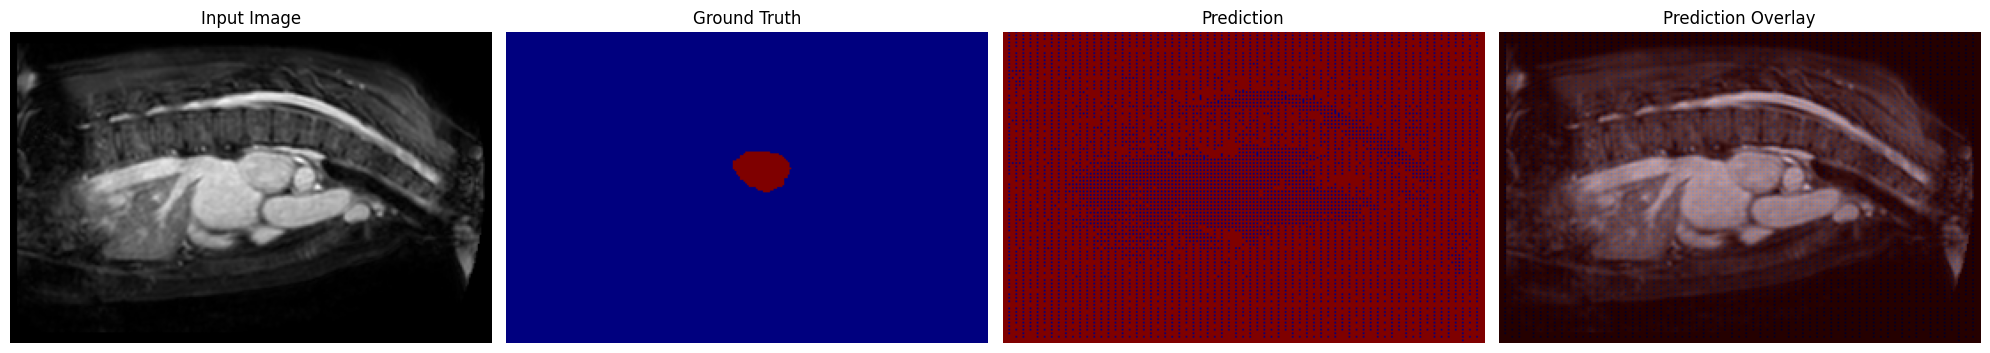

In [17]:
# Visualize prediction
image_np = image[0, 0].cpu().numpy()
label_np = (label[0, 0] != 0).cpu().numpy()  # Binary label
pred_np = prediction[0, 0].cpu().numpy()

# Middle slice
slice_idx = image_np.shape[2] // 2

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(image_np[:, :, slice_idx], cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

axes[1].imshow(label_np[:, :, slice_idx], cmap='jet')
axes[1].set_title('Ground Truth')
axes[1].axis('off')

axes[2].imshow(pred_np[:, :, slice_idx], cmap='jet')
axes[2].set_title('Prediction')
axes[2].axis('off')

# Overlay
axes[3].imshow(image_np[:, :, slice_idx], cmap='gray')
axes[3].imshow(pred_np[:, :, slice_idx], cmap='jet', alpha=0.3)
axes[3].set_title('Prediction Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.show()

## 8. Summary

## Summary

This notebook provides a complete heart segmentation training pipeline:

**Dataset Management**
- Automatic download via Kaggle API
- Dataset exploration and visualization
- Interactive slice viewer

**Training Pipeline**
- Full MONAI data preprocessing with augmentation
- 3D UNet model with batch normalization
- Dice loss + Adam optimizer with weight decay
- Learning rate scheduling
- Training/validation monitoring

**Results**
- Training curves visualization
- Best model selection and saving
- Inference on test samples
- Prediction visualization

**Training Configuration:**
- Epochs: 1 (local testing)
- Batch Size: 1
- Learning Rate: 1e-5
- Data Augmentation: Flips, Rotations, Intensity Shifts

**Next Steps:**
1. For full training (20 epochs), use: `python train.py`
2. For GPU training on Kaggle, push this code to a Kaggle kernel
3. Monitor training with TensorBoard: `tensorboard --logdir=results/tensorboard_logs`